In [1]:
import os
import glob
import shutil
from functools import partial
from matplotlib.colors import Normalize, CenteredNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
#plt.style.use('seaborn-talk') 
plt.style.use('seaborn-v0_8-talk')
import cmocean
import cftime
import datetime
import cartopy.crs as ccrs
import numpy as np
import dask
from dask.distributed import LocalCluster, Client, progress
import netCDF4 as nc
import xarray as xr

In [55]:
# files for medium resolution (0.5 deg atm, 0.1 deg ocn)

# control (RCP8.5, yearly)
cdir = '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12/'
camc = cdir+'atm/hist/yearly/rcp8.5_co2_f05_t12.cam2.h0.avg????.nc' # correct time stamps

# spinup (monthly)
sdir = '/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f05_t12/output/'
cams = cdir+'atm/hist/spinup_pd_maxcores_f05_t12.cam2.h0.????-??.nc' # add 1800 years
ices = cdir+'ice/hist/spinup_pd_maxcores_f05_t12.001.cice.h.????-??.nc'
clms = cdir+'lnd/hist/spinup_pd_maxcores_f05_t12.clm2.h0.????-??.nc'
pops = cdir+'ocn/hist/spinup_pd_maxcores_f05_t12.pop.h.????-??.nc'

# geo (monthly)
gdir = '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/'
camg = gdir+'atm/hist/mres_b.e10.B2000_CAM5.f05_t12.001.cam2.h0.????-??.nc'
iceg = gdir+'ice/hist/mres_b.e10.B2000_CAM5.f05_t12.001.cice.h.????-??.nc'
clmg = gdir+'lnd/hist/mres_b.e10.B2000_CAM5.f05_t12.001.clm2.h0.????-??.nc'
popg = gdir+'ocn/hist/mres_b.e10.B2000_CAM5.f05_t12.001.pop.h.????-??.nc'
aerg = gdir+'strataero/ozone_strataero_1999-2100_SSP585_CAMfeedback.nc'
volg = gdir+'volcaero/volcaero_1999-2100_SSP585_CAMfeedback.nc'

hrgdir = lambda i: f'/projects/0/nwo2021025/archive/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.00{i}/'
camhrg = lambda i: hrgdir(i) + f'atm/hist/hres_b.e10.B2000_CAM5.f02_t12.started_2092-12.00{i}.cam2.h0.????-??.nc'

hrsdir = '/projects/0/nwo2021025/archive/hres_b.e10.B2000_CAM5.f02_t12.spinup_from_mres_2092-01/'
camhrs = hrsdir+'atm/hist/hres_b.e10.B2000_CAM5.f02_t12.spinup_from_mres_2092-01.cam2.h0.2092-??.nc'

In [2]:
# run this instead for local testing with a subset of the data
camc = '/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/spinup_pd_maxcores_5deg.cam2.h0.????-??.nc'
camg = '/Users/jasperdejong/Documents/PhD/Geo/sai-git/sai/data/deg5/mres_b.e10.B2000_CAM5.5deg.001.cam2.h0.????-??.nc'
icec=''; iceg=''; clmc=''; clmg=''; popc=''; popg=''; aero=''; volc=''

# # to create the above data on Snellius:
# outdir = '~/copy240704/'
# filescnt = sorted(glob.glob(camc.replace('????','0194')) + glob.glob(camc.replace('????','0297')))
# filesgeo = sorted(glob.glob(camg.replace('????','2097')))
# if not os.path.exists(outdir):
#     os.mkdir(outdir)
# sh = slice(None,None,10)# select every tenth horizontal grid point
# sv = slice(None,None,3) # select every third vertical level
# for files in (filescnt, filesgeo):
#     for file in files:
#         name = os.path.basename(file).replace('f05_t12','5deg')
#         with xr.open_dataset(file) as ds:
#             dss = ds.isel(lev=sv,ilev=sv,lat=sh,slat=sh,lon=sh,slon=sh)
#             dss.to_netcdf(os.path.join(outdir,name))
#         print(name)

In [3]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=2, threads_per_worker=8, memory_limit="14GiB")
client = Client(cluster)
cluster, client

(LocalCluster(bf3adab1, 'tcp://127.0.0.1:43827', workers=2, threads=16, memory=28.00 GiB),
 <Client: 'tcp://127.0.0.1:43827' processes=2 threads=16, memory=28.00 GiB>)

In [4]:
def center_time(ds):
    """set time stamps to center of time_bnds"""
    time = ('time', ds.time_bnds.mean('nbnd').data, ds.time.attrs)
    ds = ds.assign_coords({'ctime':time}).swap_dims({'time':'ctime'})
    return ds.drop_vars('time').rename({'ctime':'time'})


def shift_time(ds, ndays):
    """shift time of dataset by ndays days"""
    dt = datetime.timedelta(days=ndays)
    t0, t1 = ds.time.data[[0,-1]]
    print(f"Shifting time period from {t0}--{t1} to {t0+dt}--{t1+dt}")
    ds = ds.assign(time_bnds=(ds.time_bnds.dims,(ds.time_bnds.compute()+dt).data,ds.time_bnds.attrs))
    return ds.assign(time=(ds.time.dims,(ds.time+dt).data,ds.time.attrs))


def wmean(ds:[xr.Dataset,xr.DataArray], w:xr.DataArray, dims, **kwargs):
    """wrapper for xarray weighted mean
    
    Input:
    ds : data to average
    w : weights
    dims : iterable of dimensions to average over
    kwargs : keyword arguments passed on to .mean(), e.g. keep_attrs
    
    Manual fixes:
        1) only apply averaging along subset of dimensions that is also in 
            dims (returns the unaveraged data if no overlapping dimensions)
        2) always copy coordinate attributes to result
        3) remove weighted operator if w.dims is no subset of ds.dims to 
            prevent broadcasting
        4) let function wmean determine keep_attrs per dataarray instead of 
            map() which applies one value to the whole dataset
    """
    if isinstance(ds, xr.Dataset):
        global WMEAN_ATTRS
        WMEAN_ATTRS = {}
        dsm = ds.map(wmean, False, [w, dims])
        if kwargs.get('keep_attrs', False):
            for v in dsm.data_vars:
                dsm[v].attrs = WMEAN_ATTRS[v] # 4
        return dsm
    if 'WMEAN_ATTRS' in globals():
        WMEAN_ATTRS[ds.name] = ds.attrs
    avgdims = tuple(set(ds.dims).intersection(dims)) # 1
    if len(avgdims)==0: # 1
        return ds
    coordattrs = {c:ds[c].attrs for c in ds.coords}
    if set(w.dims).issubset(ds.dims):
        dsm = ds.weighted(w).mean(avgdims, **kwargs)
    else: # 3
        dsm = ds.mean(avgdims, **kwargs)
    for c in dsm.coords:
        dsm[c].attrs.update(coordattrs[c]) # 2
    return dsm

In [5]:
# %%time
# cam = {
#     'cnt': shift_time(center_time(xr.open_mfdataset(camc, data_vars='minimal')), ndays=365*1800),
#     'geo': center_time(xr.open_mfdataset(camg, data_vars='minimal')),
# }
# #MERGE ERROR w_stag conflicting values

In [5]:
%%time
cam = {
    # 'cnt': shift_time(center_time(xr.open_mfdataset(camc, data_vars='minimal', coords='minimal', compat='override')), ndays=365*1800),
    'cnt': center_time(xr.open_mfdataset(camc, data_vars='minimal', coords='minimal', compat='override')),
    'geo': center_time(xr.open_mfdataset(camg, data_vars='minimal', coords='minimal', compat='override')),
    'hr1': center_time(xr.open_mfdataset(camhrg(1), data_vars='minimal', coords='minimal', compat='override')),
    'hr2': center_time(xr.open_mfdataset(camhrg(2), data_vars='minimal', coords='minimal', compat='override')),
    'hr3': center_time(xr.open_mfdataset(camhrg(3), data_vars='minimal', coords='minimal', compat='override')),
    'hr4': center_time(xr.open_mfdataset(camhrg(4), data_vars='minimal', coords='minimal', compat='override')),
    'hr5': center_time(xr.open_mfdataset(camhrg(5), data_vars='minimal', coords='minimal', compat='override')),
}

CPU times: user 2min 37s, sys: 7.16 s, total: 2min 45s
Wall time: 4min 23s


In [56]:
cam['hrs'] = center_time(xr.open_mfdataset(camhrs, data_vars='minimal', coords='minimal', compat='override'))

In [ ]:
ice = {
    'cnt': center_time(xr.open_mfdataset(icec)),
    'geo': center_time(xr.open_mfdataset(iceg)),
}

In [ ]:
clm = {
    'cnt': center_time(xr.open_mfdataset(clmc)),
    'geo': center_time(xr.open_mfdataset(clmg)),
}

In [ ]:
pop = {
    'cnt': center_time(xr.open_mfdataset(popc, parallel=True)),
    'geo': center_time(xr.open_mfdataset(popg, parallel=True)),
}

In [7]:
for k in cam:
    print(k, len(cam[k].time))

cnt 101
geo 648
hr1 48
hr2 24
hr3 25
hr4 24
hr5 24


In [32]:

cam['hr1'].TREFHT.rolling(time=12, center=True).mean('time').isel(time=slice(6,-1,12))

<xarray.DataArray 'TREFHT' (time: 4, lat: 768, lon: 1152)> Size: 14MB
dask.array<getitem, shape=(4, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * time     (time) object 32B 2093-06-16 00:00:00 ... 2096-06-16 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

## CAM H0

In [34]:
%%time
VAR = 'TREFHT'
Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'hr1':(wmean(cam['hr1'][VAR], cam['hr1'].gw, ('lat','lon'), keep_attrs=True).
           rolling(time=12, center=True).mean('time').isel(time=slice(6,-1,12)).compute()),
    'hr2':(wmean(cam['hr2'][VAR], cam['hr2'].gw, ('lat','lon'), keep_attrs=True).
           rolling(time=12, center=True).mean('time').isel(time=slice(6,-1,12)).compute()),
    'hr3':(wmean(cam['hr3'][VAR], cam['hr3'].gw, ('lat','lon'), keep_attrs=True).
           rolling(time=12, center=True).mean('time').isel(time=slice(6,-1,12)).compute()),
    'hr4':(wmean(cam['hr4'][VAR], cam['hr4'].gw, ('lat','lon'), keep_attrs=True).
           rolling(time=12, center=True).mean('time').isel(time=slice(6,-1,12)).compute()),
    'hr5':(wmean(cam['hr5'][VAR], cam['hr5'].gw, ('lat','lon'), keep_attrs=True).
           rolling(time=12, center=True).mean('time').isel(time=slice(6,-1,12)).compute()),
}

CPU times: user 11.1 s, sys: 599 ms, total: 11.7 s
Wall time: 1min 18s


In [36]:
Y['hr1'].time

<xarray.DataArray 'time' (time: 4)> Size: 32B
array([cftime.DatetimeNoLeap(2093, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2094, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2095, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2096, 6, 16, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 32B 2093-06-16 00:00:00 ... 2096-06-16 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

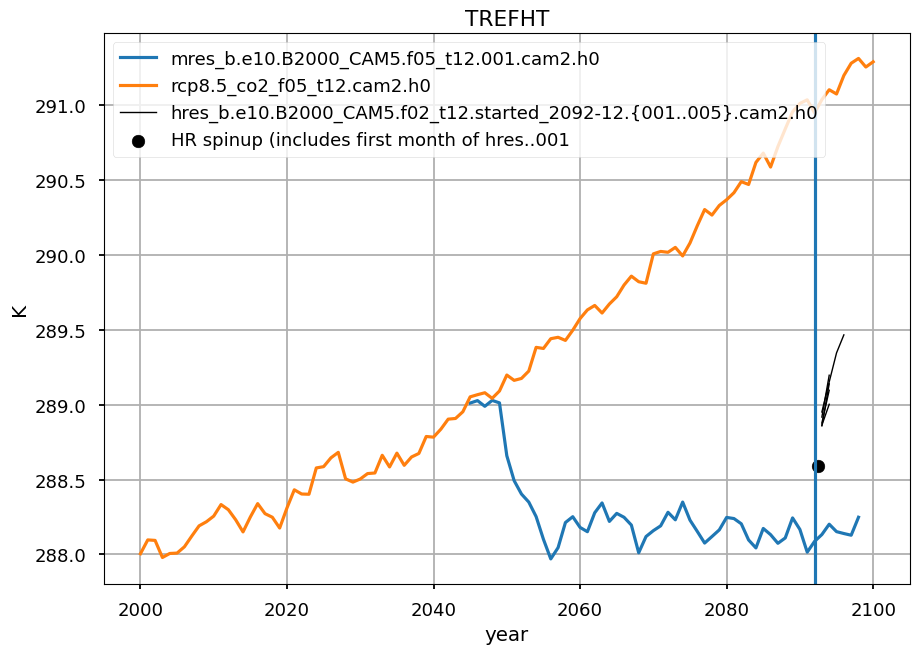

In [71]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
sc = plt.plot(Y['hr1'].time.dt.year, Y['hr1'], c='k', lw=1, label=('.'.join(os.path.basename(camhrg(1)).split('.')[:-2])).replace('001','{001..005}'))
plt.plot(Y['hr2'].time.dt.year, Y['hr2'], c='k', lw=1)
plt.plot(Y['hr3'].time.dt.year, Y['hr3'], c='k', lw=1)
plt.plot(Y['hr4'].time.dt.year, Y['hr4'], c='k', lw=1)
plt.plot(Y['hr5'].time.dt.year, Y['hr5'], c='k', lw=1)
plt.scatter(2092.5, 288.59113117, c='k', label='HR spinup (includes first month of hres..001')
plt.grid()
plt.gca().axvline(2092)
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

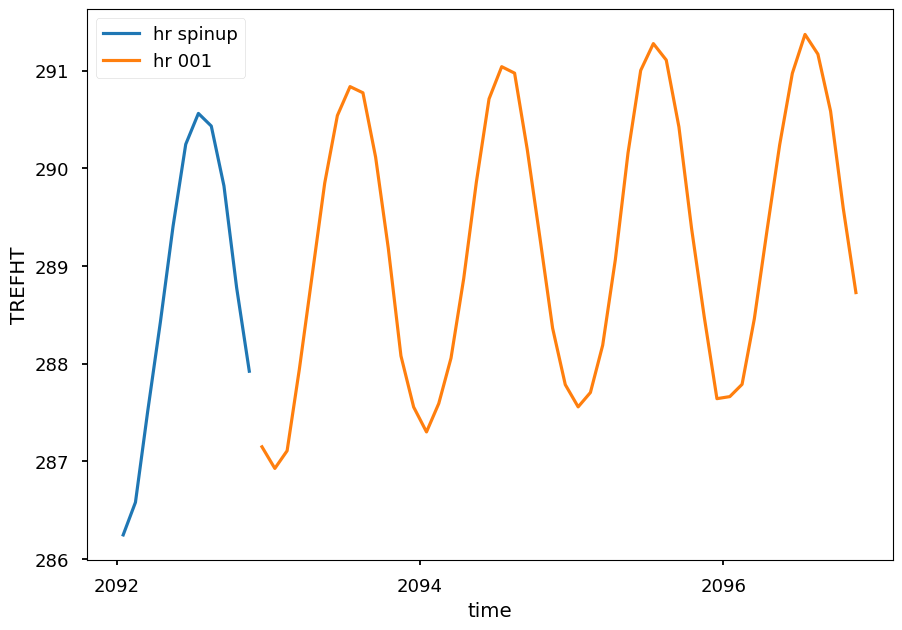

In [59]:
wmean(cam['hrs'].TREFHT, cam['hrs'].gw, ('lat','lon')).plot(label='hr spinup')
wmean(cam['hr1'].TREFHT, cam['hr1'].gw, ('lat','lon')).plot(label='hr 001')
plt.legend()

In [62]:
TREFHT001 = xr.merge((cam['hrs'].TREFHT, cam['hr1'].TREFHT, cam['hrs'].gw, cam['hr1'].gw))

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 249.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [67]:
wmean(TREFHT001.TREFHT, TREFHT001.gw, ('lat', 'lon')).sel(time=slice('2092','2095')).groupby('time.year').mean().values

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 249.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


array([288.59113117, 288.98490062, 289.17052315, 289.33341436])

In [20]:
%%time
VAR = 'FSNT'
Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 5.55 s, sys: 402 ms, total: 5.95 s
Wall time: 59.9 s


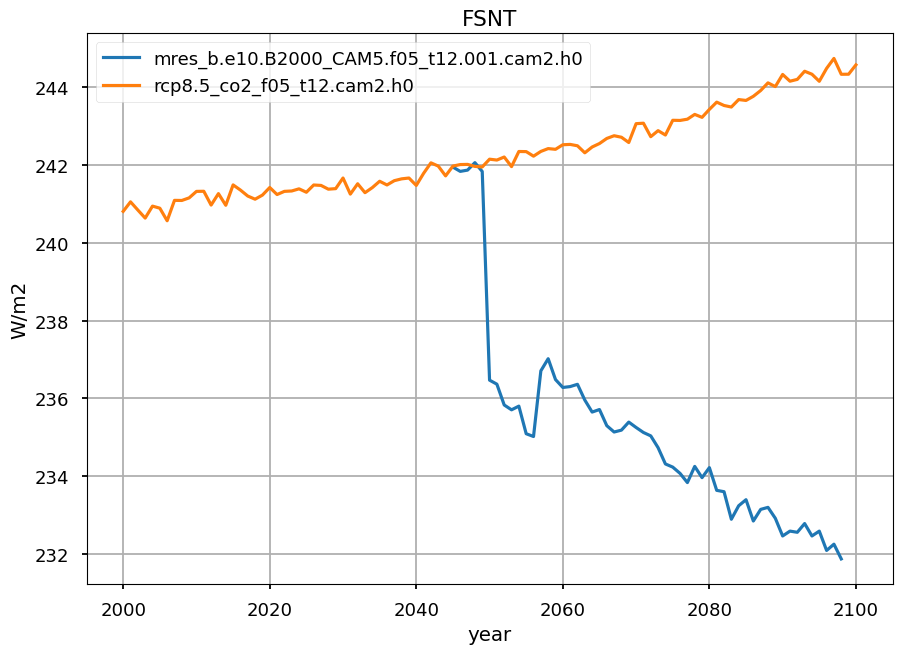

In [21]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [40]:
%%time
VAR = 'T700'
Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 5.8 s, sys: 394 ms, total: 6.19 s
Wall time: 59.3 s


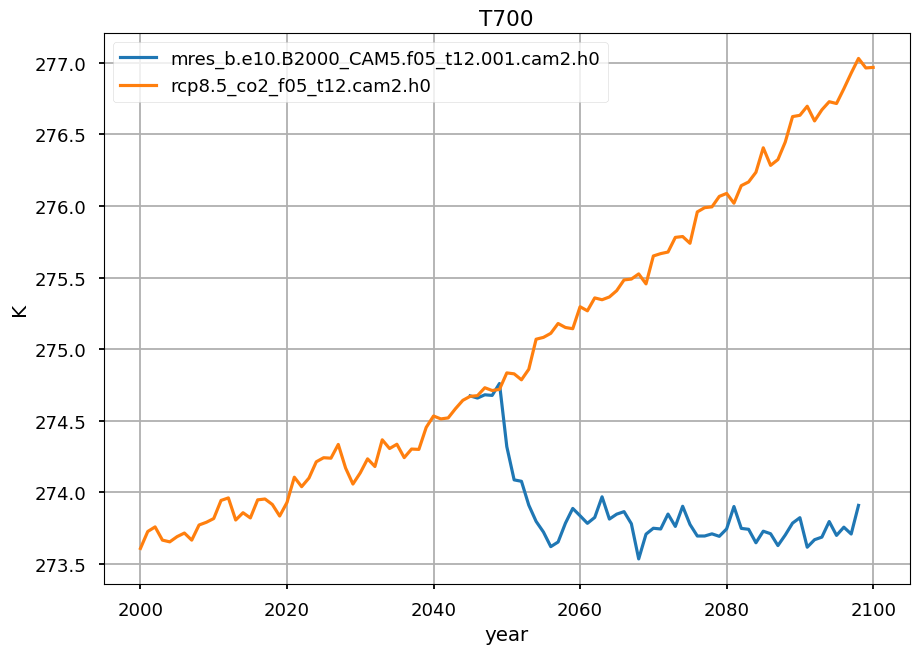

In [41]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [34]:
%%time
VAR = 'FLNT'
Y = {
    'geo':(wmean(cam['geo'][VAR], cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR], cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 8.44 s, sys: 720 ms, total: 9.16 s
Wall time: 1min 2s


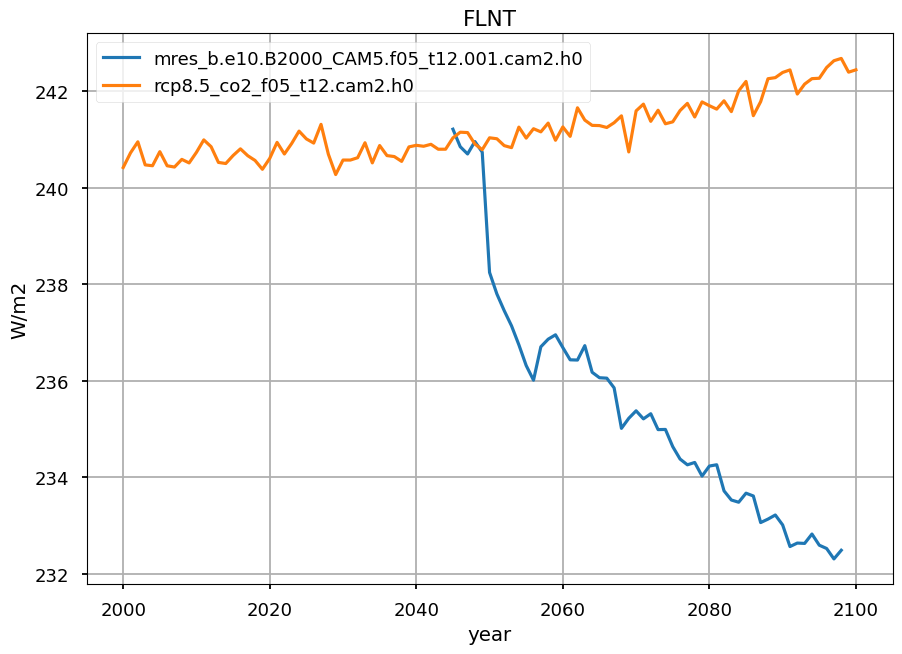

In [35]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title(VAR); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [11]:
%%time
VAR = 'U'
Y = {
    'geo':(wmean(cam['geo'][VAR].isel(lev=-1), cam['geo'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(wmean(cam['cnt'][VAR].isel(lev=-1), cam['cnt'].gw, ('lat','lon'), keep_attrs=True).
           groupby('time.year').mean(keep_attrs=True).compute()),
}

CPU times: user 5.59 s, sys: 366 ms, total: 5.96 s
Wall time: 59.1 s


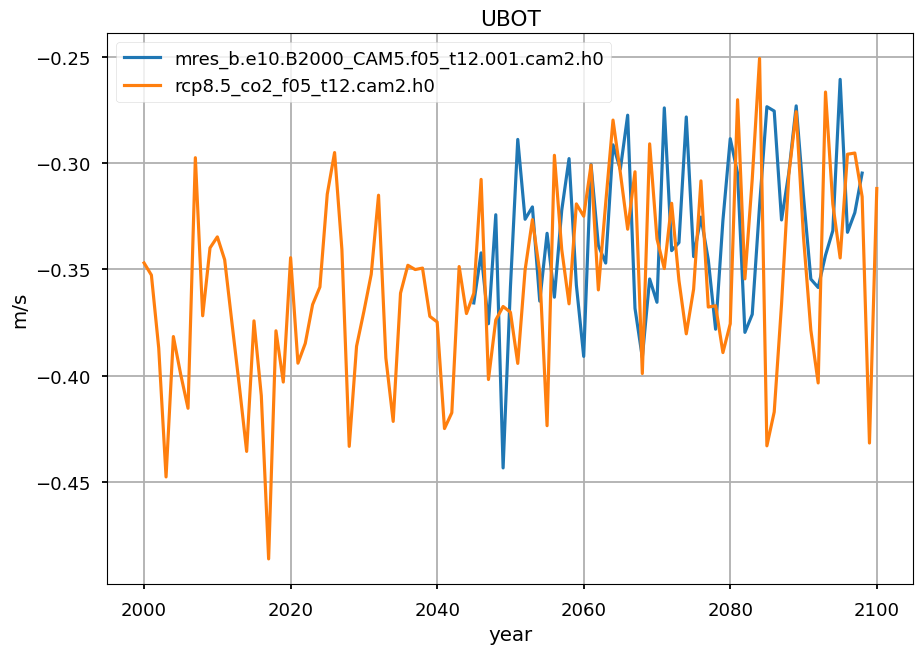

In [12]:
# Plot time series
plt.plot(Y['geo'].year, Y['geo'], label='.'.join(os.path.basename(camg).split('.')[:-2]))
plt.plot(Y['cnt'].year, Y['cnt'], label='.'.join(os.path.basename(camc).split('.')[:-2]))
plt.grid()
plt.title("UBOT"); plt.ylabel(Y['geo'].units); plt.xlabel('year')
plt.legend()

In [11]:
%%time
VAR = 'TREFHT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2045 2049
cnt: 2045 2049
CPU times: user 315 ms, sys: 23.9 ms, total: 339 ms
Wall time: 1.98 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

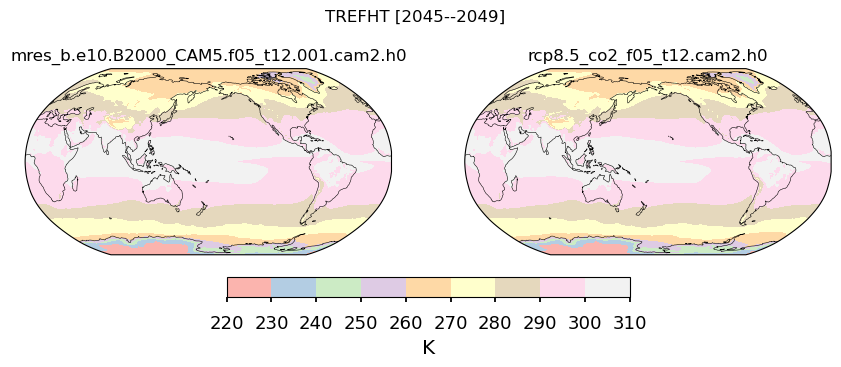

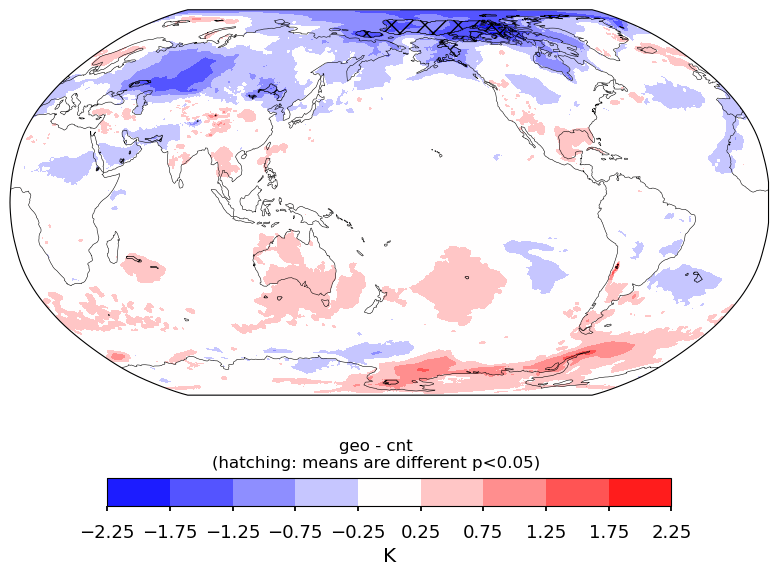

In [17]:
# Plot maps
levels = np.arange(220,311,10)
levels2 = np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [31]:
%%time
VAR = 'FSNT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

geo: 2045 2049 45.815277099609375 357.1092834472656
cnt: 2045 2049 45.68666458129883 358.0787048339844
CPU times: user 265 ms, sys: 33.9 ms, total: 299 ms
Wall time: 916 ms


CPU times: user 1min 27s, sys: 9.53 s, total: 1min 36s
Wall time: 1min 28s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

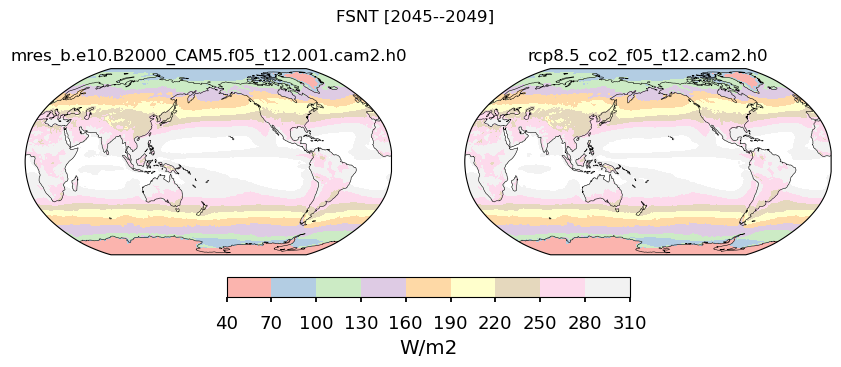

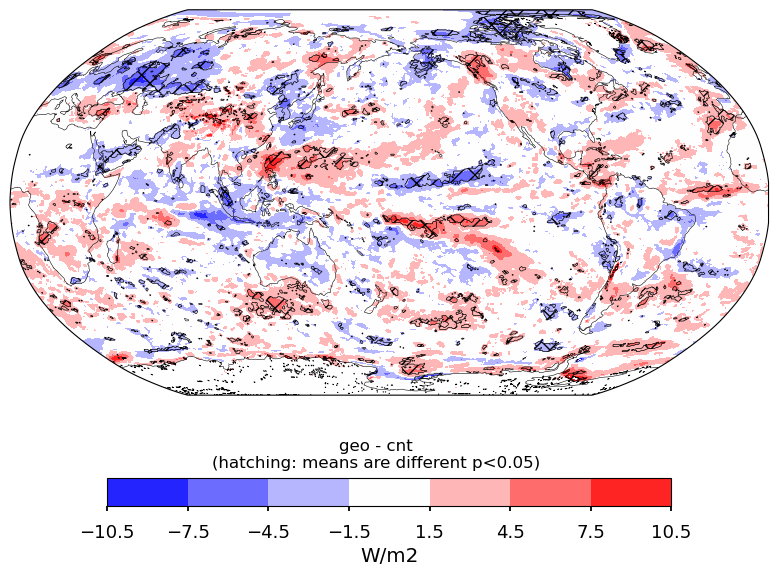

In [33]:
%%time
levels = np.arange(40,311,10)
levels2 = np.arange(-10.5,10.51,3)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [37]:
%%time
VAR = 'FLNT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 126.06214141845703 297.1809997558594
cnt: 2045 2049 126.2330322265625 300.9821472167969
geo: 127.29048919677734 294.67596435546875
cnt: 127.0342788696289 297.1031188964844
dif: -10.543930053710938 8.924224853515625
CPU times: user 333 ms, sys: 28.8 ms, total: 362 ms
Wall time: 2.64 s


CPU times: user 13.1 s, sys: 688 ms, total: 13.8 s
Wall time: 13.3 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

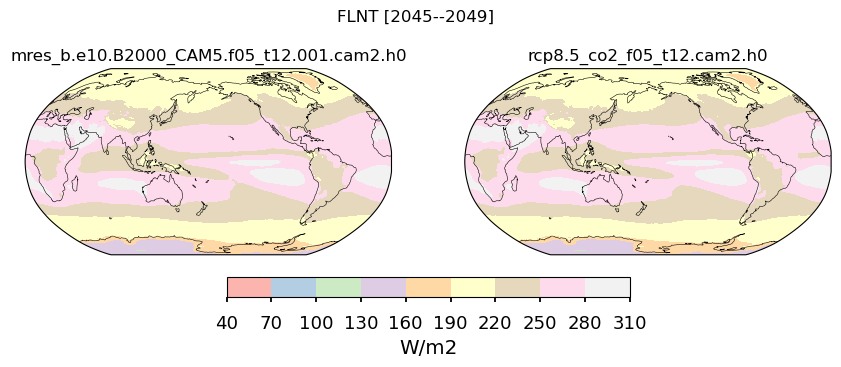

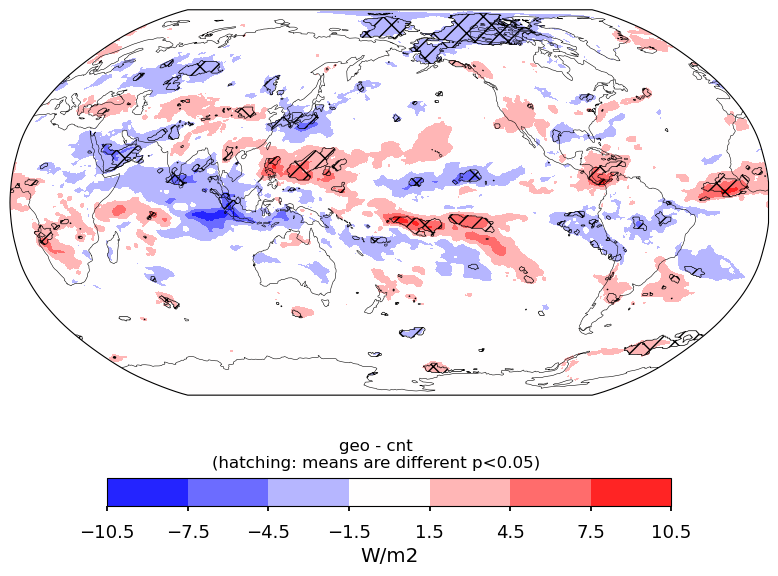

In [38]:
%%time
levels = np.arange(40,311,10)
levels2 = np.arange(-10.5,10.51,3)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [42]:
%%time
VAR = 'T700'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 222.7403564453125 286.3219299316406
cnt: 2045 2049 221.27841186523438 286.2886657714844
geo: 223.7391357421875 286.1101989746094
cnt: 223.7789306640625 286.1544494628906
dif: -1.4141082763671875 0.813873291015625
CPU times: user 313 ms, sys: 28.2 ms, total: 342 ms
Wall time: 2.43 s


CPU times: user 6.47 s, sys: 404 ms, total: 6.87 s
Wall time: 6.59 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

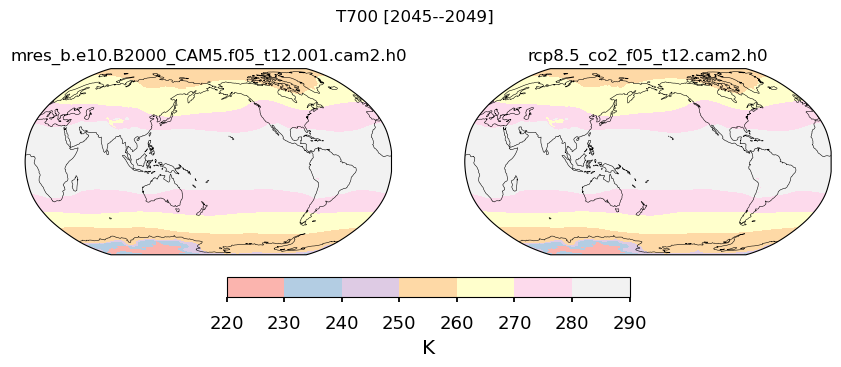

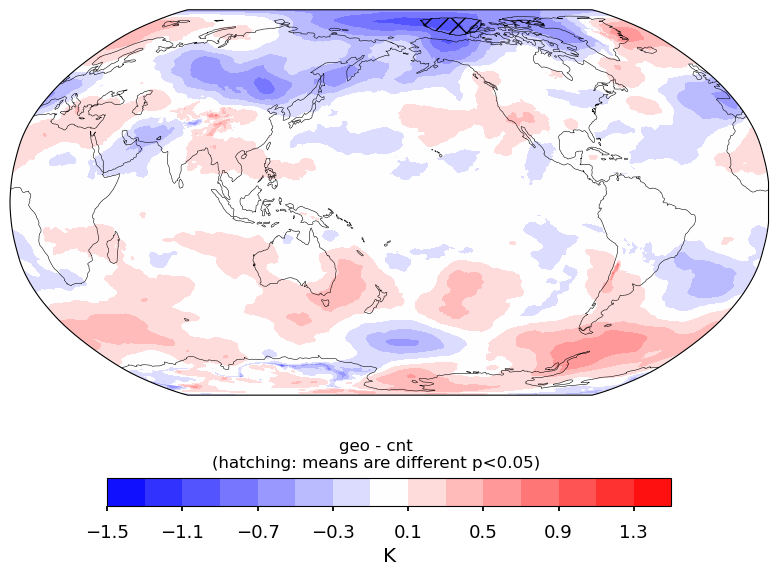

In [44]:
%%time
levels = np.arange(220,291,10)
levels2 = np.arange(-1.5,1.51,.2)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [7]:
%%time
VAR = 'U'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].isel(lev=-1).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].isel(lev=-1).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 -13.150174140930176 16.37430763244629
cnt: 2045 2049 -12.934591293334961 16.550683975219727
geo: -12.822675704956055 15.807580947875977
cnt: -12.706661224365234 15.892970085144043
dif: -0.9646300673484802 1.2082653045654297
CPU times: user 452 ms, sys: 40.4 ms, total: 493 ms
Wall time: 7.09 s


CPU times: user 13.9 s, sys: 1.08 s, total: 15 s
Wall time: 14.3 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

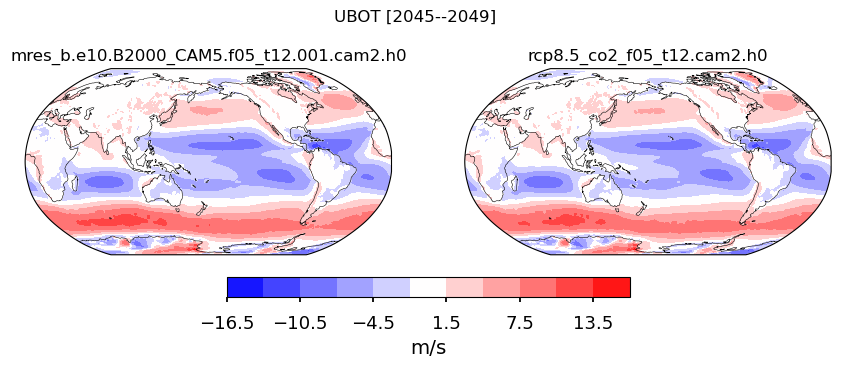

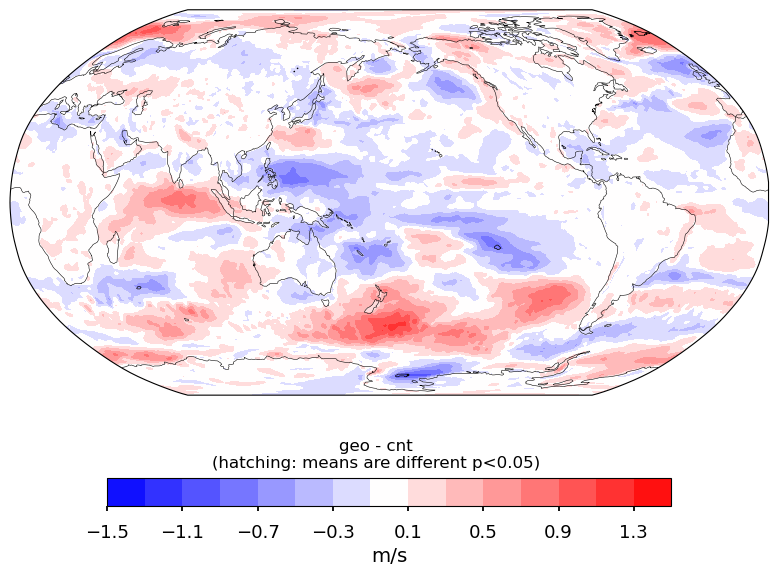

In [11]:
%%time
levels = np.arange(-16.5,16.51,3)
levels2 = np.arange(-1.5,1.51,.2)
cmap = 'bwr'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'], levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"UBOT [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)

In [20]:
%%time
VAR = 'U'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].mean('lon', keep_attrs=True).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
    'cnt':(cam['cnt'][VAR].mean('lon', keep_attrs=True).sel(time=tslice).groupby('time.year').mean(keep_attrs=True)).compute(),
}
print('geo:',Y['geo'].year.min().values, Y['geo'].year.max().data, Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].year.min().values, Y['cnt'].year.max().data, Y['cnt'].min().data, Y['cnt'].max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2).compute()
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year))).compute()

Y['geo'] = Y['geo'].mean('year', keep_attrs=True).compute()
Y['cnt'] = Y['cnt'].mean('year', keep_attrs=True).compute()

print('geo:',Y['geo'].min().data, Y['geo'].max().data)
print('cnt:',Y['cnt'].min().data, Y['cnt'].max().data)
print('dif:',(Y['geo']-Y['cnt']).min().data, (Y['geo']-Y['cnt']).max().data)

geo: 2045 2049 -20.20597267150879 51.48232650756836
cnt: 2045 2049 -19.403488159179688 52.57223892211914
geo: -18.669437408447266 50.1750373840332
cnt: -18.64817237854004 51.06236267089844
dif: -1.1798362731933594 0.9276547431945801
CPU times: user 415 ms, sys: 37.7 ms, total: 453 ms
Wall time: 4.22 s


CPU times: user 77.9 ms, sys: 3.05 ms, total: 80.9 ms
Wall time: 78.8 ms


Text(0.5, 0.3, 'geo - cnt\n(hatching: means are different p<0.05)')

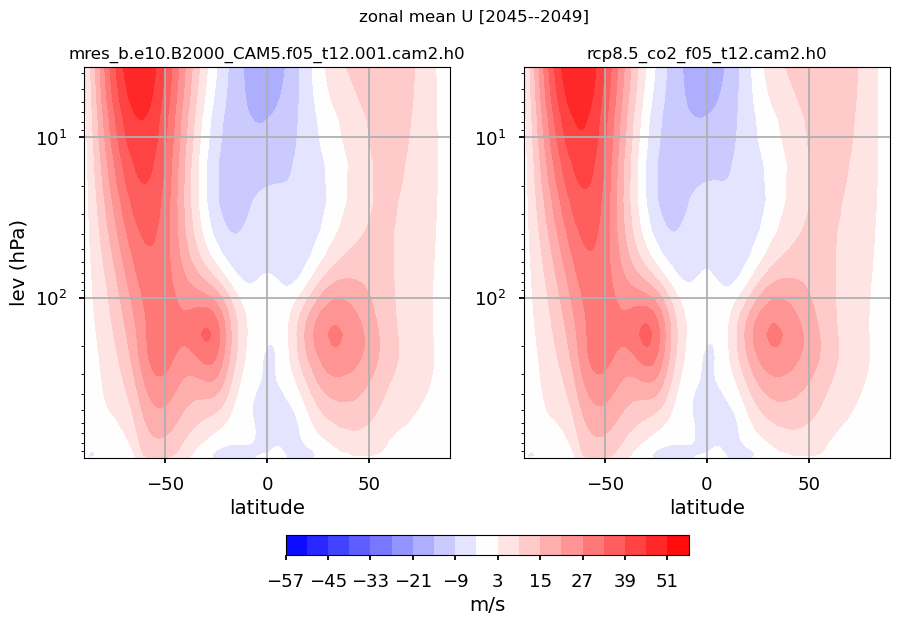

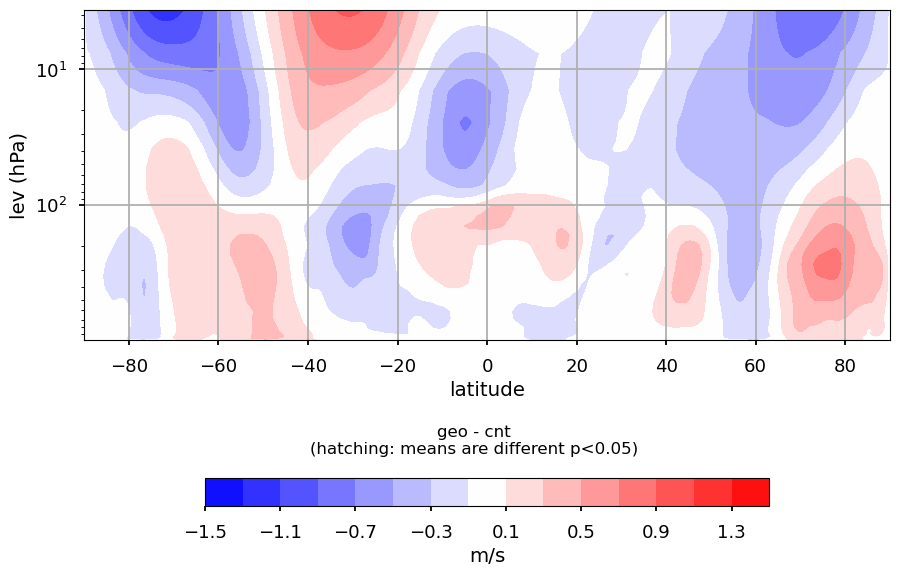

In [69]:
%%time
levels = np.arange(-57,57.1,6)
levels2 = np.arange(-1.5,1.51,.2)
cmap = 'bwr'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2)
p0 = ax[0].contourf(Y['geo'].lat, Y['geo'].lev, Y['geo'], levels=levels, cmap=cmap)
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[0].invert_yaxis()
ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('lev (hPa)')
ax[1].contourf(Y['cnt'].lat, Y['cnt'].lev, Y['cnt'], levels=levels, cmap=cmap)
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[1].invert_yaxis()
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel('latitude')
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.14, label=Y['cnt'].units)
fig.suptitle(f"zonal mean U [{tslice.start}--{tslice.stop}]",y=.96)

fig2 = plt.figure()
ax2 = plt.axes()
pd = ax2.contourf(Y['geo'].lat, Y['geo'].lev, (Y['geo']-Y['cnt']), levels=levels2, cmap='bwr')
cs = ax2.contourf(t.lat, t.lev, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0)
ct = ax2.contour(t.lat, t.lev, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5)
#ax2.coastlines()
ax2.invert_yaxis()
ax2.set_yscale('log')
ax2.grid()
ax2.set_ylabel('lev (hPa)')
ax2.set_xlabel('latitude')
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, pad=.25, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.30)